# Problem framing

**1. Objective**: predict the outcome of a web session, if the user will make a purchase or not (revenue or not revenue). 


**2. Features**:
  - 'Administrative', 'Informational' and 'ProductRelated' refer to a category of pages. Their value is the count of pages of that category that are visited in the session. 
  - The '\_Duration' columns are expressed in seconds. 
  - 'BounceRates', 'ExitRates' and 'PageValues' are metrics from Google Analytics that refer to a page. The value of these columns is an average of all the pages visited in the session.
  - 'Bounce Rate': percentage of visitors who enter the site from that page and then leave
  - 'Exit Rate': for all pageviews to the page, the percentage that were the last in the session. 
  - 'PageValues': represents the average value for a web page that a user visited before completing an e-commerce transaction.
  - 'Special Day': indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with a transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentine’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 
  - Other columns: operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.
  - Revenue: outcome we want to predict. It indicates whether the session ended with a transaction or not. 
  
**3. Performance metric**: we will evaluate our model with R2 in cross validation. We are aiming for an average R2 above 0.90.

# Libraries

In [94]:
# Base libraries: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Imputers:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator

# Outlier extractors:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Resamplers: 
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

# Scaler:
from sklearn.preprocessing import StandardScaler

# Models:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model selection: 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [19]:
plt.rcParams["figure.figsize"] = (12, 12)

In [96]:
warnings.filterwarnings("ignore")

# EDA

In [5]:
data = pd.read_csv('online_shoppers_intention.csv')

In [7]:
data.shape

(12330, 18)

In [6]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [8]:
data.tail()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
12325,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False
12329,0.0,0.0,0.0,0.0,3.0,21.250000,0.000000,0.066667,0.000000,0.0,Nov,3,2,1,2,New_Visitor,True,False


In [10]:
data.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
12059,2.0,20.150000,0.0,0.0,60.0,1521.150000,0.003333,0.015278,16.436373,0.0,Nov,2,4,1,2,Returning_Visitor,False,True
9676,1.0,51.500000,0.0,0.0,27.0,818.316667,0.007407,0.017354,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,False,False
2090,3.0,46.500000,0.0,0.0,16.0,402.690476,0.000000,0.012500,0.000000,0.0,Mar,2,4,1,1,Returning_Visitor,True,False
3833,0.0,0.000000,0.0,0.0,17.0,182.000000,0.000000,0.037500,0.000000,0.0,May,2,4,4,3,Returning_Visitor,False,False
2560,9.0,331.166667,4.0,154.0,154.0,8038.325302,0.007333,0.027963,0.000000,0.0,May,2,2,1,5,Returning_Visitor,False,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [11]:
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


<AxesSubplot:>

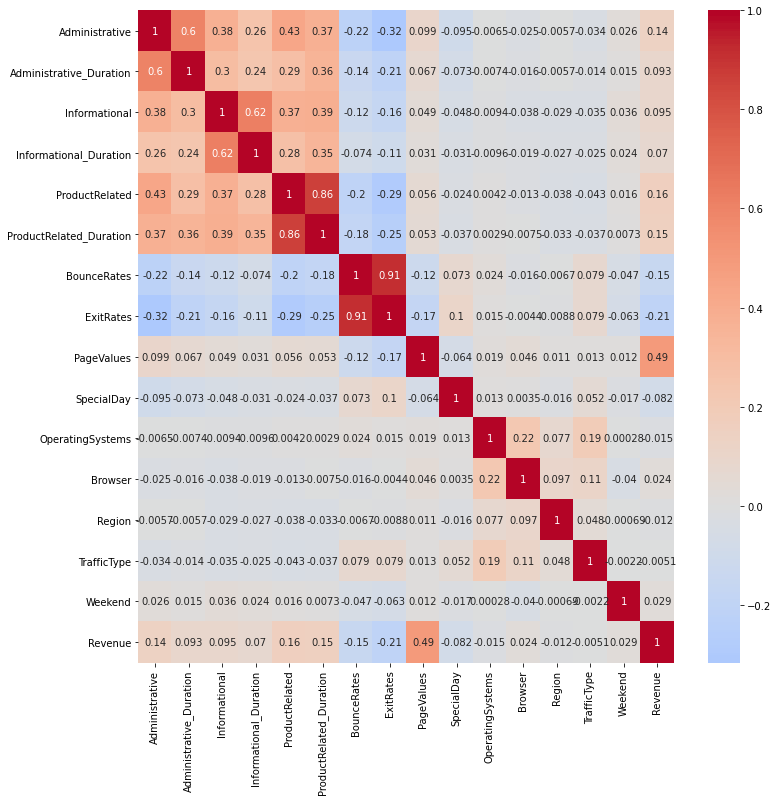

In [21]:
sns.heatmap(data=data.corr(), center=0, cmap='coolwarm', annot=True)

# Preprocessing

## Categorical variable encoding

### Months

In [23]:
data['Month'].value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

In [34]:
data['Month'] = data['Month'].apply(lambda x: 'Jun' if x == 'June' else x)

In [37]:
data['Month'] = data['Month'].apply(lambda x: datetime.strptime(x, "%b").month)

### Visitor Types

In [38]:
data['VisitorType'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [39]:
data_visitors_type = pd.get_dummies(data['VisitorType'], drop_first=True)

In [40]:
data = pd.concat([data, data_visitors_type], axis=1)
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Other,Returning_Visitor
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,Returning_Visitor,False,False,0,1
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,Returning_Visitor,False,False,0,1
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,Returning_Visitor,False,False,0,1
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,Returning_Visitor,False,False,0,1
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,Returning_Visitor,True,False,0,1


In [41]:
data.drop(['VisitorType'], axis=1, inplace=True)

## Missing values

Testing two different imputers: SimpleImputer and KNNImputer

In [22]:
data.isna().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

### SimpleImputer

In [68]:
simple = SimpleImputer(missing_values=np.nan, strategy='mean')

In [52]:
data_clean = pd.DataFrame(simple.fit_transform(data), columns=data.columns)
data_clean.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Other,Returning_Visitor
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2.0,4.0,1.0,9.0,3.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2.0,3.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2.0,3.0,3.0,1.0,4.0,1.0,0.0,0.0,1.0


In [53]:
data_clean['missing'] = data['Administrative'].isna()

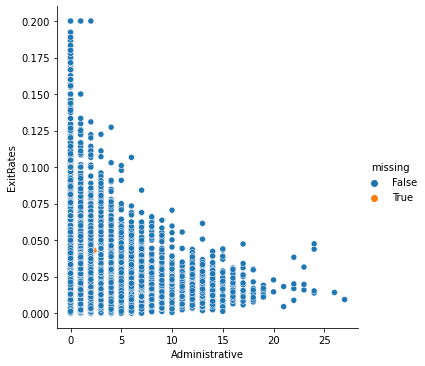

In [54]:
sns.relplot(x='Administrative', y='ExitRates', hue='missing', data=data_clean)

### KNN

In [67]:
knn = KNNImputer()

In [55]:
data_clean = pd.DataFrame(knn.fit_transform(data), columns=data.columns)

In [57]:
data_clean['missing'] = data['Administrative'].isna()

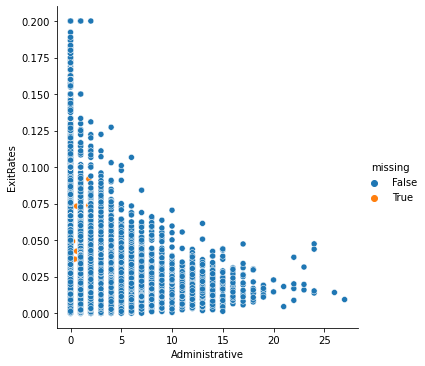

In [60]:
sns.relplot(x='Administrative', y='ExitRates', hue='missing', data=data_clean)

### IterativeImputer

In [66]:
iterative = IterativeImputer()

In [63]:
data_clean = pd.DataFrame(iterative.fit_transform(data), columns=data.columns)

In [64]:
data_clean['missing'] = data['Administrative'].isna()

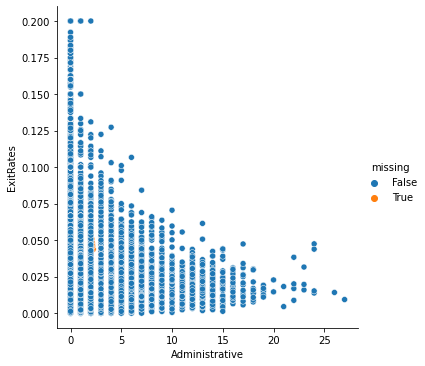

In [65]:
sns.relplot(x='Administrative', y='ExitRates', hue='missing', data=data_clean)

### Evaluating the imputers

In [69]:
rf = RandomForestClassifier()

In [73]:
y = data['Revenue']

In [72]:
for imputer in [simple, knn, iterative]:
    X = imputer.fit_transform(data.drop('Revenue', axis=1))
    print(imputer.__class__.__name__, np.mean(cross_val_score(rf, X, y)))

SimpleImputer 0.8936739659367395
KNNImputer 0.8957826439578265
IterativeImputer 0.894890510948905


We will use the KNNImputer because it has a slightly better score than the others. 

In [74]:
X_imp = knn.fit_transform(data.drop('Revenue', axis=1))

## Outlier extraction

We will test two methors of outlier extraction: LocalOutlierFactor and IsolationForest.

In [75]:
def OutlierExtractor(extractor, X, y):
    pred = extractor.fit_predict(X)
    return (X[pred==1,:], y[pred==1])

In [79]:
for extractor in [LocalOutlierFactor(), IsolationForest()]:
    X_out, y_out = OutlierExtractor(extractor, X_imp, y)
    print(extractor.__class__.__name__, np.mean(cross_val_score(rf, X, y)))

LocalOutlierFactor 0.8934306569343067
IsolationForest 0.894647201946472


We will use the IsolationForest because it has a slightly better score. 

In [80]:
X_out, y_out = OutlierExtractor(IsolationForest(), X_imp, y)

## Scaling

In [98]:
sc = StandardScaler()

In [99]:
X_std = sc.fit_transform(X_out)

## Balancing the data

When we run out model it seems like we have a good accuracy score, but if we look at the classification report we can see that the precision and recall are low for the True class.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y_out, test_size = 0.4, random_state=42)

In [101]:
y_pred = rf.fit(X_train, y_train).predict(X_test)

In [102]:
accuracy_score(y_test, y_pred)

0.9014396456256921

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.97      0.94      3833
        True       0.75      0.53      0.62       682

    accuracy                           0.90      4515
   macro avg       0.83      0.75      0.78      4515
weighted avg       0.89      0.90      0.89      4515



This is due to the training dataset being unbalanced: there are very few instances of the True class compared to the False class. 

In [108]:
plt.rcParams["figure.figsize"] = (6,6)

<AxesSubplot:xlabel='Revenue', ylabel='count'>

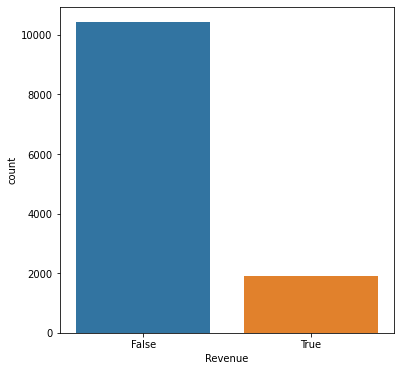

In [109]:
sns.countplot(data['Revenue'])

We will test 4 different oversamplers: SMOTE, BorderlineSMOTE, SMOTETomek, SMOTEENN. We will not use undersampling techniques because we don't want to lose any data. 

In [110]:
for resampler in (SMOTE(), BorderlineSMOTE(), SMOTETomek(), SMOTEENN()):
    X_res, y_res = resampler.fit_resample(X_std, y_out)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.4, random_state=42)
    y_pred = rf.fit(X_train, y_train).predict(X_test)
    print(resampler.__class__.__name__, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred))

SMOTE 0.9311330561330561               precision    recall  f1-score   support

       False       0.95      0.91      0.93      3816
        True       0.92      0.95      0.93      3880

    accuracy                           0.93      7696
   macro avg       0.93      0.93      0.93      7696
weighted avg       0.93      0.93      0.93      7696

BorderlineSMOTE 0.9307432432432432               precision    recall  f1-score   support

       False       0.95      0.91      0.93      3816
        True       0.91      0.95      0.93      3880

    accuracy                           0.93      7696
   macro avg       0.93      0.93      0.93      7696
weighted avg       0.93      0.93      0.93      7696

SMOTETomek 0.9409464215877982               precision    recall  f1-score   support

       False       0.95      0.93      0.94      3814
        True       0.93      0.95      0.94      3857

    accuracy                           0.94      7671
   macro avg       0.94      0.94     

The best resampler is SMOTEENN.

In [112]:
X_res, y_res = SMOTEENN().fit_resample(X_std, y_out)

<AxesSubplot:xlabel='Revenue', ylabel='count'>

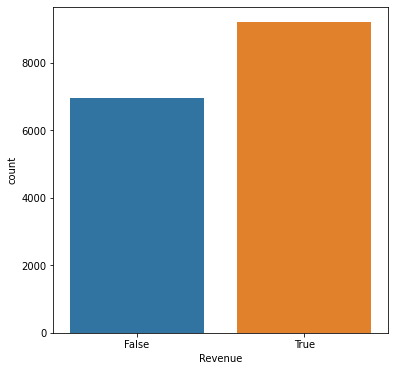

In [113]:
sns.countplot(y_res)

# Testing several classifiers with cross-validation

We will test 3 classifiers: Logistic Regression, Support Vector Classifier and Random Forest Classifier.

In [115]:
for clf in [LogisticRegression(), SVC(), RandomForestClassifier()]:
    print(clf.__class__.__name__, np.mean(cross_val_score(clf, X_res, y_res)))

LogisticRegression 0.8659490287468857
SVC 0.9060543014607868
RandomForestClassifier 0.9545138601603893


The best model is the RandomForestClassifier. 

# Hyperparameter Tuning

In [85]:
rf = RandomForestClassifier()

In [87]:
# We check the default parameters of our model
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [118]:
# We set some parameters to create a random grid for a Randomized search of hyperparameters: 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [119]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [120]:
model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [94]:
model.fit(X_res, y_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [96]:
model.best_score_

0.8777081710020734

In [97]:
# best model resulting from the randomized search
model.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=400)

In [98]:
# parameters of the best model
model.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

We will evaluate the model from the randomized search vs out previous model (a Random Forest with the default parameters):

In [99]:
cross_val_score_base_model = np.mean(cross_val_score(rf, X_res, y_res))
cross_val_score_base_model

0.9566963005448809

In [100]:
best_random = model.best_estimator_

In [101]:
cross_val_score_random = np.mean(cross_val_score(best_random, X_res, y_res))
cross_val_score_random

0.9587037568110123

After a randomized search we have narrowed down our choice of hyperparameters and we can do a new search with GridSearch. We will set a grid with parameter values that are around the best parameters we have obtained with the randomized search. 

In [104]:
# best params from randomized search:
# {'bootstrap': True,
# 'max_depth': 70,
# 'max_features': 'auto',
# 'min_samples_leaf': 4,
# 'min_samples_split': 10,
# 'n_estimators': 400}

# params for grid search:
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70, 80, 90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [300, 400, 500]
}

In [105]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [106]:
grid_search.fit(X_res, y_res)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


c:\users\júlia\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.87690511 0.87667568 0.87788031
 0.87461065 0.87650356 0.87593009        nan        nan        nan
 0.87122653 0.87323416 0.87208693 0.87174273 0.87289006 0.87065295
        nan        nan        nan 0.86812907 0.86715401 0.86841596
 0.86789971 0.86721127 0.8678423         nan        nan        nan
 0.87610209 0.87793764 0.87627421 0.87478285 0.87581539 0.87805237
        nan        nan        nan 0.87048085 0.87093978 0.87248844
 0.87243106 0.87254586 0.872087          nan        nan        nan
 0.8668098  0.86870279 0.86698185 0.86778496 0.86744077 0.86898951
        nan        nan        nan 0.87724928 0.87679043 0.87713455
 0.87782303 0.87690516 0.8761021         nan        nan        nan
 0.87105446 0.87168545 0.87329151 0.87329152 0.87266053 0.87116913
        nan        nan  

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [50, 60, 70, 80, 90],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [300, 400, 500]},
             verbose=2)

In [107]:
grid_search.best_score_

0.8780523655822159

In [108]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       min_samples_split=3, n_estimators=500)

In [109]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 500}

In [110]:
best_grid = grid_search.best_estimator_

In [111]:
cross_val_score_grid = np.mean(cross_val_score(best_grid, X_res, y_res))
cross_val_score_grid

0.9594493834241469

Our model has slightly improved with each hyperparameter search: 
- Score of the base model: 0.9566963005448809
- Score of the best reandomized search model: 0.9587037568110123
- Score of the best grid search model: 0.9594493834241469

# Evaluating the model

In [122]:
# model with the best hyperparameters from the grid search
rf = RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt', min_samples_leaf= 1,
                       min_samples_split=3, n_estimators=500)

In [123]:
np.mean(cross_val_score(rf, X_res, y_res))

0.9590316657013892

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.4, random_state=42)

In [126]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       min_samples_split=3, n_estimators=500)

In [127]:
y_pred = rf.predict(X_test)

In [128]:
confusion_matrix(y_test, y_pred)

array([[2675,  120],
       [ 107, 3562]], dtype=int64)

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.96      0.96      2795
        True       0.97      0.97      0.97      3669

    accuracy                           0.96      6464
   macro avg       0.96      0.96      0.96      6464
weighted avg       0.96      0.96      0.96      6464



All the metrics in the classification report are above 0.90, as well as the mean of the cross validation scores, so we can consider that we have built a successful model. 